# import the libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
import librosa
import librosa.display
from google.colab import drive
drive.mount('/content/drive')
import os

import tensorflow as tf

PREV_IMAGE_HEIGHT = 480
PREV_IMAGE_WIDTH = 640
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 16
N_CHANNELS = 3
N_CLASSES = 15
EPOCHS = 50
AUTO = tf.data.AUTOTUNE


Mounted at /content/drive


# DIVIDING TRAIN, VALIDATION AND TEST

mel spectrograms

In [ ]:
import tensorflow as tf
import os

#Since we saved the spectrograms with the decibel scale and legend, we just crop the spectrogram
def preprocessing(image):

    x = 77
    y = 58
    width = 400
    height = 370

    cropped_image_array = tf.image.crop_to_bounding_box(image, y, x, height, width)
    resized_image = tf.image.resize(cropped_image_array, (256, 256))

    return resized_image

spectrogram_directory = '/content/drive/MyDrive/DeepLearningProject/data/output/mel-grams'

spec_data_train = tf.keras.preprocessing.image_dataset_from_directory(
    directory=spectrogram_directory,
    seed=0,
    shuffle=True,
    image_size=(PREV_IMAGE_HEIGHT, PREV_IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.15,
    subset='training')

spec_data_test = tf.keras.preprocessing.image_dataset_from_directory(
    directory=spectrogram_directory,
    seed=0,
    shuffle=True,
    image_size=(PREV_IMAGE_HEIGHT, PREV_IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.15,
    subset='validation',)


#crop, normalization of images and one_hot encoding of classes
spec_data_train = spec_data_train.map(lambda x, y: (preprocessing(x)/255, tf.one_hot(y, N_CLASSES)))
spec_data_test = spec_data_test.map(lambda x, y: (preprocessing(x)/255, tf.one_hot(y, N_CLASSES)))
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

Found 4680 files belonging to 15 classes.
Using 3978 files for training.
Found 4680 files belonging to 15 classes.
Using 702 files for validation.


In [ ]:
val_samples = spec_data_train.cardinality().numpy()*0.2
val_ds_mel = spec_data_train.take(val_samples)
train_dss_mel = spec_data_train.skip(val_samples)
test_ds_mel = spec_data_test

In [ ]:
import tensorflow as tf
#load augmented train dataset
augmented_train_mix=tf.data.Dataset.load('/content/drive/MyDrive/DeepLearningProject/data/output/augmented_dataset/ds_mel_augmented_definitive_2.tfrecord')

stft spectrogam

In [ ]:
import tensorflow as tf
import os

#Since we saved the spectrograms with the decibel scale and legend, we just crop the spectrogram
def preprocessing(image):

    x = 77
    y = 58
    width = 400
    height = 370

    cropped_image_array = tf.image.crop_to_bounding_box(image, y, x, height, width)
    resized_image = tf.image.resize(cropped_image_array, (256, 256))

    return resized_image

spectrogram_directory = '/content/drive/MyDrive/DeepLearningProject/data/output/stft-grams'

spec_data_train = tf.keras.preprocessing.image_dataset_from_directory(
    directory=spectrogram_directory,
    seed=0,
    shuffle=True,
    image_size=(PREV_IMAGE_HEIGHT, PREV_IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.15,
    subset='training')

spec_data_test = tf.keras.preprocessing.image_dataset_from_directory(
    directory=spectrogram_directory,
    seed=0,
    shuffle=True,
    image_size=(PREV_IMAGE_HEIGHT, PREV_IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.15,
    subset='validation',)


#crop, normalization of images and one_hot encoding of classes
spec_data_train = spec_data_train.map(lambda x, y: (preprocessing(x)/255, tf.one_hot(y, N_CLASSES)))
spec_data_test = spec_data_test.map(lambda x, y: (preprocessing(x)/255, tf.one_hot(y, N_CLASSES)))
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

Found 4680 files belonging to 15 classes.
Using 3978 files for training.
Found 4680 files belonging to 15 classes.
Using 702 files for validation.


In [ ]:
val_samples = spec_data_train.cardinality().numpy()*0.2
val_ds_stft = spec_data_train.take(val_samples)
train_dss_stft = spec_data_train.skip(val_samples)
test_ds_stft = spec_data_test

# FIRST MODEL PROPOSED ON STFT

In [ ]:
from tensorflow.keras import regularizers
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))

# Convolutional Layer 1
model.add(tf.keras.layers.Conv2D(16, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2
model.add(tf.keras.layers.Conv2D(32, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 3
model.add(tf.keras.layers.Conv2D(64, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 4
model.add(tf.keras.layers.Conv2D(128, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 5
model.add(tf.keras.layers.Conv2D(256, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)



history = model.fit(train_dss_stft, epochs=50, validation_data=val_ds_stft, callbacks=[callback])
_, test_acc = model.evaluate(test_ds_stft)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

model_path = '/content/drive/MyDrive/DeepLearningProject/models_trained/first_model_stft_crop.h5'
# Save the model
model.save(model_path)

print("Model saved successfully at:", model_path)

Epoch 1/50
200/200 [==============================] - 13s 33ms/step - loss: 1.2983 - accuracy: 0.5783 - val_loss: 6.5183 - val_accuracy: 0.0548
Epoch 2/50
200/200 [==============================] - 8s 35ms/step - loss: 0.5954 - accuracy: 0.8021 - val_loss: 4.4306 - val_accuracy: 0.1314
Epoch 3/50
200/200 [==============================] - 8s 34ms/step - loss: 0.3636 - accuracy: 0.8817 - val_loss: 2.1936 - val_accuracy: 0.4541
Epoch 4/50
200/200 [==============================] - 8s 35ms/step - loss: 0.2436 - accuracy: 0.9205 - val_loss: 0.3320 - val_accuracy: 0.8967
Epoch 5/50
200/200 [==============================] - 8s 35ms/step - loss: 0.1721 - accuracy: 0.9480 - val_loss: 1.1148 - val_accuracy: 0.6658
Epoch 6/50
200/200 [==============================] - 8s 34ms/step - loss: 0.1108 - accuracy: 0.9674 - val_loss: 0.6051 - val_accuracy: 0.8099
Epoch 7/50
200/200 [==============================] - 8s 35ms/step - loss: 0.0719 - accuracy: 0.9803 - val_loss: 0.4880 - val_accuracy: 0.854

In [ ]:
model_path = '/content/drive/MyDrive/DeepLearningProject/models_trained/first_model_stft_crop.h5'
# Save the model
model.save(model_path)

print("Model saved successfully at:", model_path)

Model saved successfully at: /content/drive/MyDrive/DeepLearningProject/models_trained/first_model_proposed_stft.h5


# FIRST MODEL PROPOSED ON MEL

In [ ]:

from tensorflow.keras import regularizers

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
# Convolutional Layer 1
model.add(tf.keras.layers.Conv2D(16, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2
model.add(tf.keras.layers.Conv2D(32, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 3
model.add(tf.keras.layers.Conv2D(64, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 4
model.add(tf.keras.layers.Conv2D(128, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 5
model.add(tf.keras.layers.Conv2D(256, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])



history = model.fit(train_dss_mel, epochs=50, validation_data=val_ds_mel, callbacks=[callback])
_, test_acc = model.evaluate(test_ds_mel)
print("Test accuracy: {:.2f}%".format(test_acc * 100))




model_path = '/content/drive/MyDrive/DeepLearningProject/models_trained/first_model_proposed_mel_crop.h5'
# Save the model
model.save(model_path)

print("Model saved successfully at:", model_path)

Found 4680 files belonging to 15 classes.
Using 3978 files for training.
Found 4680 files belonging to 15 classes.
Using 702 files for validation.
200
49
44
Epoch 1/50
200/200 [==============================] - 287s 1s/step - loss: 1.5881 - accuracy: 0.4966 - val_loss: 11.6376 - val_accuracy: 0.0599
Epoch 2/50
200/200 [==============================] - 7s 29ms/step - loss: 0.9413 - accuracy: 0.6828 - val_loss: 11.3973 - val_accuracy: 0.1314
Epoch 3/50
200/200 [==============================] - 7s 30ms/step - loss: 0.6579 - accuracy: 0.7799 - val_loss: 16.8555 - val_accuracy: 0.1263
Epoch 4/50
200/200 [==============================] - 7s 29ms/step - loss: 0.3995 - accuracy: 0.8644 - val_loss: 3.5876 - val_accuracy: 0.5000
Epoch 5/50
200/200 [==============================] - 7s 30ms/step - loss: 0.3477 - accuracy: 0.8917 - val_loss: 1.0912 - val_accuracy: 0.6365
Epoch 6/50
200/200 [==============================] - 7s 29ms/step - loss: 0.2467 - accuracy: 0.9230 - val_loss: 0.9749 - val

# **FIRST MODEL PROPOSED MEL AUGMENTED**

In [13]:
#ugmented_train_mix




model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
# Convolutional Layer 1
model.add(tf.keras.layers.Conv2D(16, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2
model.add(tf.keras.layers.Conv2D(32, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 3
model.add(tf.keras.layers.Conv2D(64, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 4
model.add(tf.keras.layers.Conv2D(128, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 5
model.add(tf.keras.layers.Conv2D(256, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])



history = model.fit(augmented_train_mix
, epochs=50, validation_data=val_ds_mel, callbacks=[callback])
_, test_acc = model.evaluate(test_ds_mel)
print("Test accuracy: {:.2f}%".format(test_acc * 100))



# Save the model
model.save(model_path)

print("Model saved successfully at:", model_path)



NameError: ignored

# SECOND MODEL PROPOSED: CNN on stft

In [ ]:

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
# Convolutional Layer 1
model.add(tf.keras.layers.Conv2D(32, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Convolutional Layer 2
model.add(tf.keras.layers.Conv2D(64, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Convolutional Layer 3
model.add(tf.keras.layers.Conv2D(128, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Convolutional Layer 4
model.add(tf.keras.layers.Conv2D(256, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Convolutional Layer 5
model.add(tf.keras.layers.Conv2D(512, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Convolutional Layer 6
model.add(tf.keras.layers.Conv2D(512, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Convolutional Layer 7
model.add(tf.keras.layers.Conv2D(1024, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Convolutional Layer 8
model.add(tf.keras.layers.Conv2D(1024, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
# Fully connected Layer 1
model.add(tf.keras.layers.Dense(2048))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.4))
# Fully connected Layer 2
model.add(tf.keras.layers.Dense(2048))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Training
history = model.fit(train_dss_stft, epochs=50, validation_data=val_ds_stft,callbacks=[callback])

# Evaluation
_, test_acc = model.evaluate(test_ds_stft)
print("Test accuracy: {:.2f}%".format(test_acc * 100))



Found 4680 files belonging to 15 classes.
Using 3978 files for training.
Found 4680 files belonging to 15 classes.
Using 702 files for validation.
200
49
44
Epoch 1/50
200/200 [==============================] - 1983s 9s/step - loss: 2.4057 - accuracy: 0.2796 - val_loss: 17.8783 - val_accuracy: 0.0663
Epoch 2/50
200/200 [==============================] - 46s 196ms/step - loss: 1.8640 - accuracy: 0.4123 - val_loss: 13.3114 - val_accuracy: 0.1467
Epoch 3/50
200/200 [==============================] - 42s 181ms/step - loss: 1.5974 - accuracy: 0.4966 - val_loss: 8.2702 - val_accuracy: 0.1735
Epoch 4/50
200/200 [==============================] - 47s 195ms/step - loss: 1.3433 - accuracy: 0.5745 - val_loss: 10.4204 - val_accuracy: 0.1773
Epoch 5/50
200/200 [==============================] - 46s 198ms/step - loss: 1.1995 - accuracy: 0.6274 - val_loss: 3.3877 - val_accuracy: 0.3673
Epoch 6/50
200/200 [==============================] - 48s 198ms/step - loss: 1.0151 - accuracy: 0.6738 - val_loss: 8

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))

# Convolutional Layer 1
model.add(tf.keras.layers.Conv2D(32, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2
model.add(tf.keras.layers.Conv2D(64, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 3
model.add(tf.keras.layers.Conv2D(128, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 4
model.add(tf.keras.layers.Conv2D(256, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 5
model.add(tf.keras.layers.Conv2D(512, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 6
model.add(tf.keras.layers.Conv2D(512, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 7
model.add(tf.keras.layers.Conv2D(1024, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 8
model.add(tf.keras.layers.Conv2D(1024, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())

# Fully connected Layer 1
model.add(tf.keras.layers.Dense(2048))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.4))

# Fully connected Layer 2
model.add(tf.keras.layers.Dense(2048))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)


# Training
history = model.fit(train_dss_mel, epochs=50, validation_data=val_ds_mel,callbacks=[callback])

# Evaluation
_, test_acc = model.evaluate(test_ds_mel)
print("Test accuracy: {:.2f}%".format(test_acc * 100))



In [ ]:
model_path = '/content/drive/MyDrive/DeepLearningProject/models_trained/second_model_proposed_mel.h5'

# Save the model
model.save(model_path)

# Print the success message
print("Model saved successfully at:", model_path)


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50


# Load the pre-trained rest-net model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS))


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

base_model.trainable = True

model = tf.keras.models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(N_CLASSES, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_dss_stft, validation_data=val_ds_stft, epochs=50,callbacks=[callback])

Epoch 1/50
200/200 [==============================] - 445s 2s/step - loss: 1.2215 - accuracy: 0.6221 - val_loss: 5.8590 - val_accuracy: 0.0548
Epoch 2/50
200/200 [==============================] - 54s 234ms/step - loss: 0.4187 - accuracy: 0.8663 - val_loss: 10.5695 - val_accuracy: 0.0574
Epoch 3/50
200/200 [==============================] - 53s 234ms/step - loss: 0.2163 - accuracy: 0.9302 - val_loss: 16.6795 - val_accuracy: 0.0599
Epoch 4/50
200/200 [==============================] - 50s 215ms/step - loss: 0.1375 - accuracy: 0.9584 - val_loss: 7.3336 - val_accuracy: 0.1059
Epoch 5/50
200/200 [==============================] - 56s 245ms/step - loss: 0.1100 - accuracy: 0.9659 - val_loss: 1.1088 - val_accuracy: 0.6901
Epoch 6/50
200/200 [==============================] - 53s 233ms/step - loss: 0.0609 - accuracy: 0.9806 - val_loss: 0.1492 - val_accuracy: 0.9643
Epoch 7/50
200/200 [==============================] - 50s 212ms/step - loss: 0.0913 - accuracy: 0.9734 - val_loss: 0.3290 - val_ac

In [ ]:
_, test_acc = model.evaluate(test_ds_stft)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

44/44 [==============================] - 128s 2s/step - loss: 0.2756 - accuracy: 0.9174
Test accuracy: 91.74%


In [ ]:
# Specify the path to save the model
model_path = '/content/drive/MyDrive/DeepLearningProject/models_trained/restnet50_trainable_stft.h5'

# Save the model
model.save(model_path)

print("Model saved successfully at:", model_path)


Model saved successfully at: /content/drive/MyDrive/DeepLearningProject/models_trained/restnet50_trainable_stft.h5


Found 4680 files belonging to 15 classes.
Using 3978 files for training.
Found 4680 files belonging to 15 classes.
Using 702 files for validation.
200
49
44
44/44 [==============================] - 8s 114ms/step - loss: 3.3965 - accuracy: 0.3932
Test accuracy: 39.32%


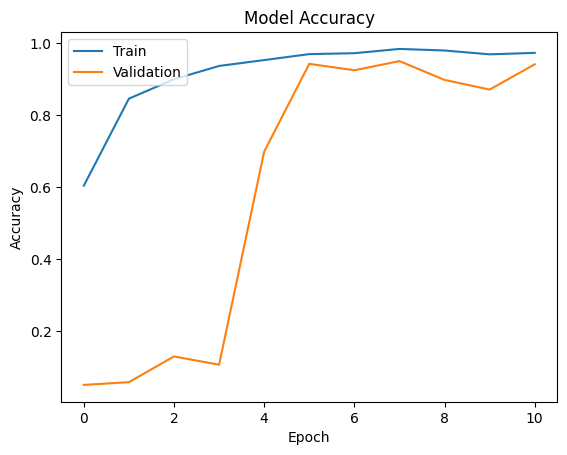

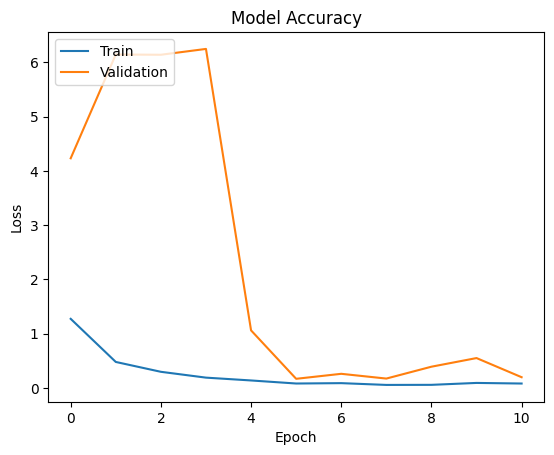

In [ ]:
# Specify the path to the saved model
model_path = '/content/drive/MyDrive/DeepLearningProject/models_trained/restnet50_trainable_stft.h5'

# Load the saved model
loaded_model = tf.keras.models.load_model(model_path)

# Evaluate the loaded model on the test dataset
test_loss, test_acc = loaded_model.evaluate(test_ds)
# Plot accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()




# RESTNET TRAINABLE ON MEL

# CNN+RNN DATI AUMENTED

In [ ]:

model = tf.keras.models.Sequential()

# Convolutional Layer 1
model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2
model.add(tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 3
model.add(tf.keras.layers.Conv2D(256, kernel_size=3, activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Reshape the output from Conv layer to fit the LSTM layer
model.add(tf.keras.layers.Reshape((-1, 256)))

# LSTM Layer
model.add(tf.keras.layers.LSTM(128))

# Fully connected layer
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))

# Output layer
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(augmented_train_mix, epochs=50, validation_data=val_ds_mel, callbacks=[callback])
_, test_acc = model.evaluate(test_ds_mel)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

model_path = '/content/drive/MyDrive/DeepLearningProject/models_trained/cnn_and_rnn_model_mel_augmented.h5'
# # Save the model
model.save(model_path)

print("Model saved successfully at:", model_path)

Epoch 1/50
331/331 [==============================] - 18s 45ms/step - loss: 2.5338 - accuracy: 0.1515 - val_loss: 2.4705 - val_accuracy: 0.1722
Epoch 2/50
331/331 [==============================] - 15s 44ms/step - loss: 2.2428 - accuracy: 0.2454 - val_loss: 1.9211 - val_accuracy: 0.3265
Epoch 3/50
331/331 [==============================] - 15s 44ms/step - loss: 2.0053 - accuracy: 0.3132 - val_loss: 1.8196 - val_accuracy: 0.3406
Epoch 4/50
331/331 [==============================] - 15s 44ms/step - loss: 1.8258 - accuracy: 0.3700 - val_loss: 1.6354 - val_accuracy: 0.4171
Epoch 5/50
331/331 [==============================] - 15s 44ms/step - loss: 1.7130 - accuracy: 0.4133 - val_loss: 1.5921 - val_accuracy: 0.4235
Epoch 6/50
331/331 [==============================] - 15s 44ms/step - loss: 1.5639 - accuracy: 0.4811 - val_loss: 1.4627 - val_accuracy: 0.4987
Epoch 7/50
331/331 [==============================] - 16s 47ms/step - loss: 1.4229 - accuracy: 0.5359 - val_loss: 1.2413 - val_accuracy:

In [ ]:
# Load the model
model = tf.keras.models.load_model('/content/drive/MyDrive/DeepLearningProject/models_trained/cnn_and_rnn_model_mel_augmented.h5')

# Evaluate the model
loss, accuracy = model.evaluate(test_ds_mel)
print("Test accuracy: {:.2f}%".format(accuracy * 100))


# CNN+RNN DATI NON AUGMENTED

In [ ]:


model = tf.keras.models.Sequential()

# Convolutional Layer 1
model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2
model.add(tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 3
model.add(tf.keras.layers.Conv2D(256, kernel_size=3, activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Reshape the output from Conv layer to fit the LSTM layer
model.add(tf.keras.layers.Reshape((-1, 256)))

# LSTM Layer
model.add(tf.keras.layers.LSTM(128))

# Fully connected layer
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))

# Output layer
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_dss_mel, epochs=50, validation_data=val_ds_mel, callbacks=[callback])
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))



model_path = '/content/drive/MyDrive/DeepLearningProject/models_trained/cnn_and_rnn_model_NORMAL_NOT_augmented.h5'
# # Save the model
model.save(model_path)

print("Model saved successfully at:", model_path)

Epoch 1/50
200/200 [==============================] - 17s 60ms/step - loss: 2.6530 - accuracy: 0.1018 - val_loss: 2.5401 - val_accuracy: 0.1569
Epoch 2/50
200/200 [==============================] - 12s 53ms/step - loss: 2.4365 - accuracy: 0.1753 - val_loss: 2.4478 - val_accuracy: 0.1556
Epoch 3/50
200/200 [==============================] - 12s 53ms/step - loss: 2.3246 - accuracy: 0.2154 - val_loss: 2.2968 - val_accuracy: 0.2207
Epoch 4/50
200/200 [==============================] - 12s 54ms/step - loss: 2.1137 - accuracy: 0.2649 - val_loss: 2.1101 - val_accuracy: 0.2309
Epoch 5/50
200/200 [==============================] - 12s 53ms/step - loss: 1.9359 - accuracy: 0.3137 - val_loss: 1.8765 - val_accuracy: 0.3508
Epoch 6/50
200/200 [==============================] - 12s 53ms/step - loss: 1.8307 - accuracy: 0.3741 - val_loss: 1.7522 - val_accuracy: 0.3890
Epoch 7/50
200/200 [==============================] - 12s 54ms/step - loss: 1.6619 - accuracy: 0.4064 - val_loss: 1.6448 - val_accuracy:

In [ ]:

model_path = '/content/drive/MyDrive/DeepLearningProject/models_trained/cnn_and_rnn_model_NORMAL_NOT_augmented.h5'
# # Save the model
#model.save(model_path)

print("Model saved successfully at:", model_path)

Model saved successfully at: /content/drive/MyDrive/DeepLearningProject/models_trained/cnn_and_rnn_model_NORMAL_NOT_augmented.h5



#CNN + RNN EVALUATION

44/44 [==============================] - 9s 155ms/step - loss: 0.9094 - accuracy: 0.7108
Test accuracy of augmented model: 82.34%
Test accuracy of not augmented model: 71.08%


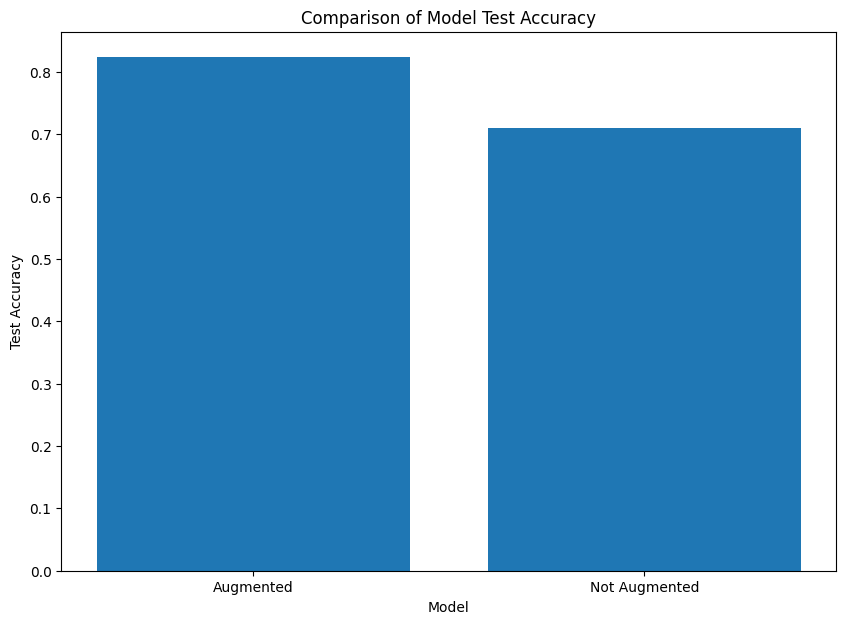

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the models
model_augmented = tf.keras.models.load_model('/content/drive/MyDrive/DeepLearningProject/models_trained/cnn_and_rnn_model_mel_augmented.h5')
model_not_augmented = tf.keras.models.load_model('/content/drive/MyDrive/DeepLearningProject/models_trained/cnn_and_rnn_model_NORMAL_NOT_augmented.h5')

# Evaluate the models
loss_augmented, accuracy_augmented = model_augmented.evaluate(
spec_data_test)
loss_not_augmented, accuracy_not_augmented = model_not_augmented.evaluate(spec_data_test)

# Print the accuracy
print("Test accuracy of augmented model: {:.2f}%".format(accuracy_augmented * 100))
print("Test accuracy of not augmented model: {:.2f}%".format(accuracy_not_augmented * 100))

# Plot the accuracy
plt.figure(figsize=(10, 7))
plt.bar(["Augmented", "Not Augmented"], [accuracy_augmented, accuracy_not_augmented])
plt.xlabel("Model")
plt.ylabel("Test Accuracy")
plt.title("Comparison of Model Test Accuracy")
plt.show()



44/44 [==============================] - 9s 176ms/step - loss: 1.0816 - accuracy: 0.7123
Test accuracy of second complex augmented model: 72.65%
Test accuracy of second complex not augmented model: 71.23%


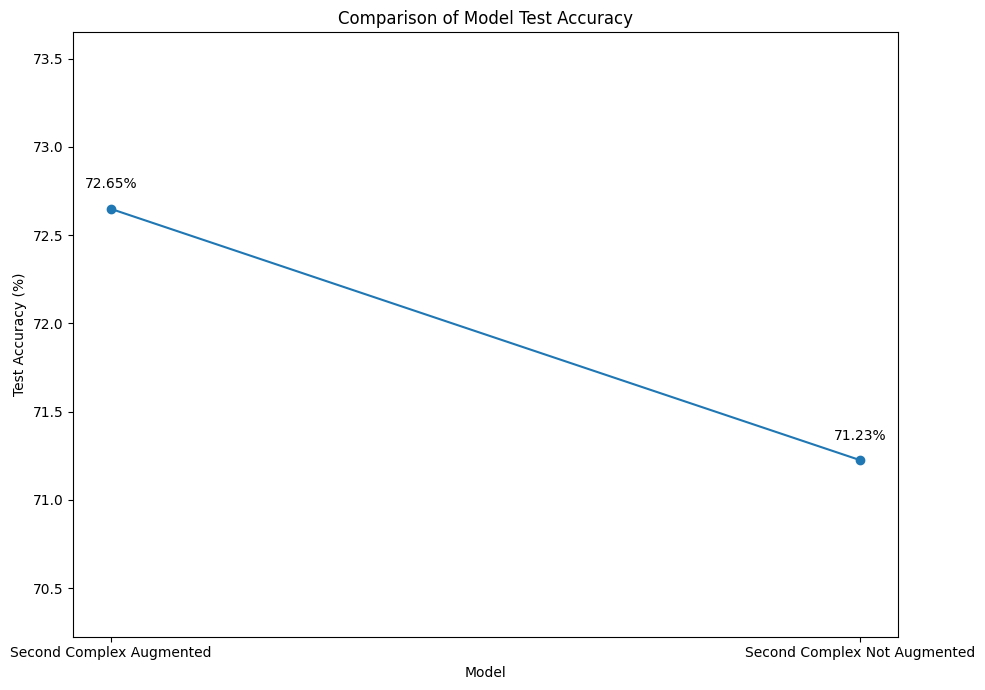

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the models
model_second_complex_augmented = tf.keras.models.load_model('/content/drive/MyDrive/DeepLearningProject/models_trained/second_complex_cnn_augmented.h5')
model_second_complex_not_augmented = tf.keras.models.load_model('/content/drive/MyDrive/DeepLearningProject/models_trained/second_complex_cnn_not_aumented_normal_data.h5')

# Assuming you have your test data in spec_data_test variable
# Evaluate the models
loss_second_complex_augmented, accuracy_second_complex_augmented = model_second_complex_augmented.evaluate(spec_data_test)
loss_second_complex_not_augmented, accuracy_second_complex_not_augmented = model_second_complex_not_augmented.evaluate(spec_data_test)

# Print the accuracy
print("Test accuracy of second complex augmented model: {:.2f}%".format(accuracy_second_complex_augmented * 100))
print("Test accuracy of second complex not augmented model: {:.2f}%".format(accuracy_second_complex_not_augmented * 100))

# Set the model names and accuracies
model_names = ["Second Complex Augmented", "Second Complex Not Augmented"]
accuracies = [accuracy_second_complex_augmented * 100, accuracy_second_complex_not_augmented * 100]

# Plot the grouped bar chart with different scales
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the accuracy values as a line plot
ax.plot(model_names, accuracies, 'o-')

# Set labels and title
ax.set_xlabel("Model")
ax.set_ylabel("Test Accuracy (%)")
ax.set_title("Comparison of Model Test Accuracy")

# Set y limits to zoom in on the accuracy range
min_accuracy = min(accuracies) - 1  # 1% below the minimum accuracy
max_accuracy = max(accuracies) + 1  # 1% above the maximum accuracy
ax.set_ylim([min_accuracy, max_accuracy])

# Display the values at the points
for i, v in enumerate(accuracies):
    ax.text(i, v + 0.1, "{:.2f}%".format(v), ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


# SECOND MODEL: COMPLEX CNN ON AUGMENTED MIX



In [ ]:


model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))

# Convolutional Layer 1
model.add(tf.keras.layers.Conv2D(32, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2
model.add(tf.keras.layers.Conv2D(64, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 3
model.add(tf.keras.layers.Conv2D(128, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 4
model.add(tf.keras.layers.Conv2D(256, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 5
model.add(tf.keras.layers.Conv2D(512, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 6
model.add(tf.keras.layers.Conv2D(512, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 7
model.add(tf.keras.layers.Conv2D(1024, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 8
model.add(tf.keras.layers.Conv2D(1024, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())

# Fully connected Layer 1
model.add(tf.keras.layers.Dense(2048))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.4))

# Fully connected Layer 2
model.add(tf.keras.layers.Dense(2048))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)











# Training
history = model.fit(augmented_train_mix, epochs=50, validation_data=val_ds,callbacks=[callback])

# Evaluation
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))



model_path = '/content/drive/MyDrive/DeepLearningProject/models_trained/second_complex_cnn_augmented.h5'
# # Save the model
model.save(model_path)

print("Model saved successfully at:", model_path)

# SECOND MODEL: COMPLEX CNN ON normal not AUGMENTED data

In [ ]:


model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))

# Convolutional Layer 1
model.add(tf.keras.layers.Conv2D(32, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2
model.add(tf.keras.layers.Conv2D(64, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 3
model.add(tf.keras.layers.Conv2D(128, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 4
model.add(tf.keras.layers.Conv2D(256, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 5
model.add(tf.keras.layers.Conv2D(512, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 6
model.add(tf.keras.layers.Conv2D(512, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 7
model.add(tf.keras.layers.Conv2D(1024, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 8
model.add(tf.keras.layers.Conv2D(1024, 3, padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())

# Fully connected Layer 1
model.add(tf.keras.layers.Dense(2048))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.4))

# Fully connected Layer 2
model.add(tf.keras.layers.Dense(2048))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)











# Training
history = model.fit(train_dss, epochs=50, validation_data=val_ds,callbacks=[callback])

# Evaluation
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))



model_path = '/content/drive/MyDrive/DeepLearningProject/models_trained/second_complex_cnn_not_aumented_normal_data.h5'
# # Save the model
model.save(model_path)

print("Model saved successfully at:", model_path)

augmented_train_mix=tf.data.Dataset.load('/content/drive/MyDrive/DeepLearningProject/data/output/augmented_dataset/ds_mel_augmented_definitive.tfrecord')

# INCEPTION V4 SU DATI AUGMENTED

In [ ]:
#INCEPTION TRAINABLE

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D

import tensorflow as tf
augmented_train_mix=tf.data.Dataset.load('/content/drive/MyDrive/DeepLearningProject/data/output/augmented_dataset/ds_mel_augmented_definitive.tfrecord')
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
N_CHANNELS= 3
N_CLASSES=15

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load the pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS))

base_model.trainable = True

model = tf.keras.models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(N_CLASSES, activation='softmax')
])

optimizer = Adam()

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(augmented_train_mix, validation_data=val_ds, epochs=50, callbacks=[callback])


_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))




# # # Save the model
# model.save(model_path)

# print("Model saved successfully at:", model_path)







# **inception dati non augmented**

In [ ]:
#INCEPTION

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D

import tensorflow as tf
augmented_train_mix=tf.data.Dataset.load('/content/drive/MyDrive/DeepLearningProject/data/output/augmented_dataset/ds_mel_augmented_definitive.tfrecord')
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
N_CHANNELS= 3
N_CLASSES=15
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Load the pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS))

# Make sure the base model is trainable
base_model.trainable = True
# Create a new model by adding layers on top of the base model
model = tf.keras.models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(N_CLASSES, activation='softmax')
])

optimizer = Adam()

# Compile the model with a low learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_dss, validation_data=val_ds, epochs=50, callbacks=[callback])


# Evaluation
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))



model_path = '/content/drive/MyDrive/DeepLearningProject/models_trained/INCEPTIONv3_data_true.h5'
# # Save the model
model.save(model_path)

print("Model saved successfully at:", model_path)


Epoch 1/50
200/200 [==============================] - 60s 95ms/step - loss: 2.3718 - accuracy: 0.2887 - val_loss: 8.8358 - val_accuracy: 0.0625
Epoch 2/50
200/200 [==============================] - 17s 77ms/step - loss: 2.2015 - accuracy: 0.3306 - val_loss: 2.9573 - val_accuracy: 0.1327
Epoch 3/50
200/200 [==============================] - 16s 71ms/step - loss: 1.8516 - accuracy: 0.4289 - val_loss: 193.7892 - val_accuracy: 0.1263
Epoch 4/50
200/200 [==============================] - 17s 77ms/step - loss: 1.5791 - accuracy: 0.5013 - val_loss: 2.4605 - val_accuracy: 0.2423
Epoch 5/50
200/200 [==============================] - 16s 72ms/step - loss: 1.4976 - accuracy: 0.5204 - val_loss: 13.1271 - val_accuracy: 0.3776
Epoch 6/50
200/200 [==============================] - 17s 76ms/step - loss: 1.1794 - accuracy: 0.6080 - val_loss: 7.0980 - val_accuracy: 0.4260
Epoch 7/50
200/200 [==============================] - 16s 71ms/step - loss: 1.0415 - accuracy: 0.6612 - val_loss: 1.3532 - val_accura

In [ ]:


import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D

import tensorflow as tf
#augmented_train_mix=tf.data.Dataset.load('/content/drive/MyDrive/DeepLearningProject/data/output/augmented_dataset/ds_mel_augmented_definitive.tfrecord')
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
N_CHANNELS= 3
N_CLASSES=15
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Load the pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS))

base_model.trainable = True

model = tf.keras.models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(N_CLASSES, activation='softmax')
])

optimizer = Adam()

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_dss, validation_data=val_ds, epochs=50, callbacks=[callback])


_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))



model_path = '/content/drive/MyDrive/DeepLearningProject/models_trained/INCEPTIONv3_data_true.h5'
# # Save the model
model.save(model_path)

print("Model saved successfully at:", model_path)


EVALUATION

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define the model names and file paths
model_names = [
    "CNN and RNN Model Mel Augmented",
    "CNN and RNN Model Normal Not Augmented",
    "First Model Mel Augmented",
    "First Model Proposed Mel Crop",
    "InceptionV3 Augmented True",
    "InceptionV3 Data True",
    "RestNet50 Mel Crop",
    "RestNet50 Mel Crop Augmented",
    "Second Complex Augmented",
    "Second Complex Not Augmented"
]
file_paths = [
    '/content/drive/MyDrive/DeepLearningProject/models_trained/cnn_and_rnn_model_mel_augmented.h5',
    '/content/drive/MyDrive/DeepLearningProject/models_trained/cnn_and_rnn_model_NORMAL_NOT_augmented.h5',
    '/content/drive/MyDrive/DeepLearningProject/models_trained/first_model_mel_augmented.h5',
    '/content/drive/MyDrive/DeepLearningProject/models_trained/first_model_proposed_mel_crop.h5',
    '/content/drive/MyDrive/DeepLearningProject/models_trained/INCEPTIONv3_augmented_true.h5',
    '/content/drive/MyDrive/DeepLearningProject/models_trained/INCEPTIONv3_data_true.h5',
    '/content/drive/MyDrive/DeepLearningProject/models_trained/restnet50_mel_crop.h5',
    '/content/drive/MyDrive/DeepLearningProject/models_trained/restnet50_mel_crop_augmented.h5',
    '/content/drive/MyDrive/DeepLearningProject/models_trained/second_complex_cnn_augmented.h5',
    '/content/drive/MyDrive/DeepLearningProject/models_trained/second_complex_cnn_not_aumented_normal_data.h5'
]

# Load the models and evaluate them
accuracies = []
for model_name, file_path in zip(model_names, file_paths):
    model = tf.keras.models.load_model(file_path)
    loss, accuracy = model.evaluate(spec_data_test)  # Assuming you have your test data in spec_data_test variable
    accuracies.append(accuracy * 100)
    print("Test accuracy of {}: {:.2f}%".format(model_name, accuracy * 100))

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.bar(model_names, accuracies, color=colormap(np.linspace(0, 1, len(categories))))
ax.set_xlabel("Model")
ax.set_ylabel("Test Accuracy (%)", color='black')
ax.set_title("Comparison of Model Test Accuracy")
ax.set_ylim([min(accuracies) - 1, max(accuracies) + 1])  # Set y-axis limit to emphasize differences
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Display the values on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, "{:.2f}%".format(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()


 1/44 [..............................] - ETA: 49:51 - loss: 13.1839 - accuracy: 0.0000e+00

44/44 [==============================] - 9s 167ms/step - loss: 0.3268 - accuracy: 0.8875
Test accuracy of First Model Proposed Mel Crop: 88.75%
44/44 [==============================] - 7s 129ms/step - loss: 22.4199 - accuracy: 0.0769
Test accuracy of First Model Proposed STFT80: 7.69%
44/44 [==============================] - 10s 169ms/step - loss: 5.8345 - accuracy: 0.2650
Test accuracy of RestNet50 Trainable STFT: 26.50%
44/44 [==============================] - 10s 180ms/step - loss: 3.1022 - accuracy: 0.4915
Test accuracy of RestNet50 Trainable MEL: 49.15%


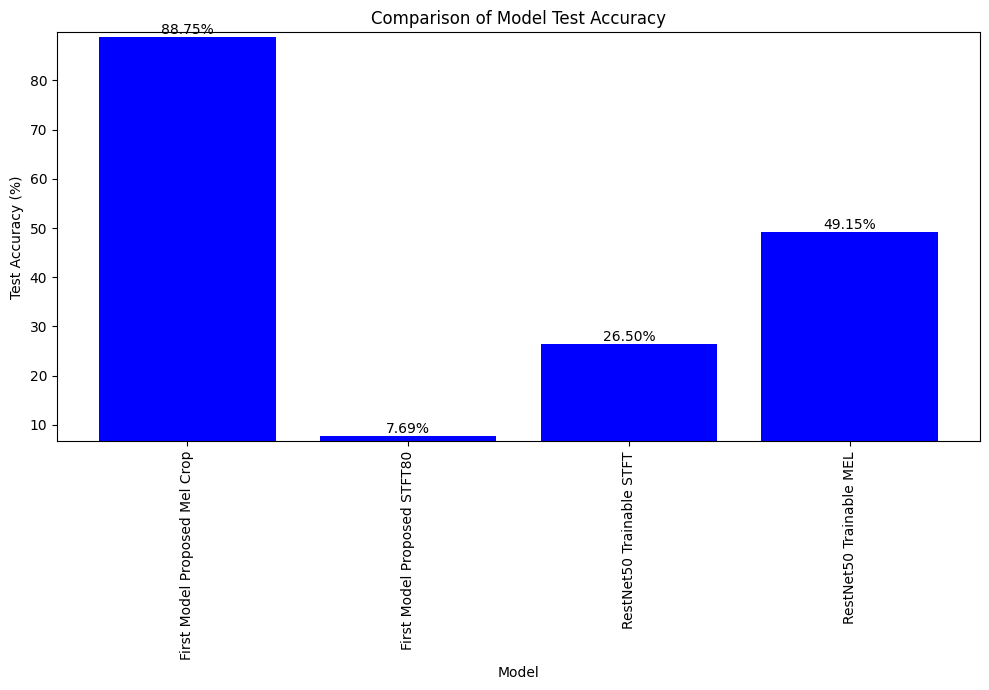

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define the model names and file paths
model_names = [
    "First Model Proposed Mel Crop",
    "First Model Proposed STFT80",
    "RestNet50 Trainable STFT",
    "RestNet50 Trainable MEL"
]
file_paths = [
    '/content/drive/MyDrive/DeepLearningProject/models_trained/first_model_proposed_mel_crop.h5',
    '/content/drive/MyDrive/DeepLearningProject/models_trained/first_model_proposed_stft80.h5',
    '/content/drive/MyDrive/DeepLearningProject/models_trained/restnet50_trainable_stft.h5',
    '/content/drive/MyDrive/DeepLearningProject/models_trained/restnet50_trainable_MEL.h5'
]

# Load the models and evaluate them
accuracies = []
for model_name, file_path in zip(model_names, file_paths):
    model = tf.keras.models.load_model(file_path)
    loss, accuracy = model.evaluate(spec_data_test)  # Assuming you have your test data in spec_data_test variable
    accuracies.append(accuracy * 100)
    print("Test accuracy of {}: {:.2f}%".format(model_name, accuracy * 100))

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.bar(model_names, accuracies, color='blue')
ax.set_xlabel("Model")
ax.set_ylabel("Test Accuracy (%)", color='black')
ax.set_title("Comparison of Model Test Accuracy")
ax.set_ylim([min(accuracies) - 1, max(accuracies) + 1])  # Set y-axis limit to emphasize differences
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Display the values on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, "{:.2f}%".format(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()


PLOT LOSS FUNCTIONS

44/44 [==============================] - 109s 2s/step - loss: 0.6387 - accuracy: 0.8234
Test loss of CNN and RNN Model Mel Augmented: 0.64
44/44 [==============================] - 111s 2s/step - loss: 0.9094 - accuracy: 0.7108
Test loss of CNN and RNN Model Normal Not Augmented: 0.91
44/44 [==============================] - 34s 729ms/step - loss: 0.2954 - accuracy: 0.8932
Test loss of First Model Mel Augmented: 0.30
44/44 [==============================] - 42s 918ms/step - loss: 0.3268 - accuracy: 0.8875
Test loss of First Model Proposed Mel Crop: 0.33
44/44 [==============================] - 121s 3s/step - loss: 0.5944 - accuracy: 0.8333
Test loss of InceptionV3 Augmented True: 0.59
44/44 [==============================] - 117s 3s/step - loss: 0.8255 - accuracy: 0.7578
Test loss of InceptionV3 Data True: 0.83
44/44 [==============================] - 181s 4s/step - loss: 0.4214 - accuracy: 0.8761
Test loss of RestNet50 Mel Crop: 0.42
44/44 [==============================] - 179s 4s/ste

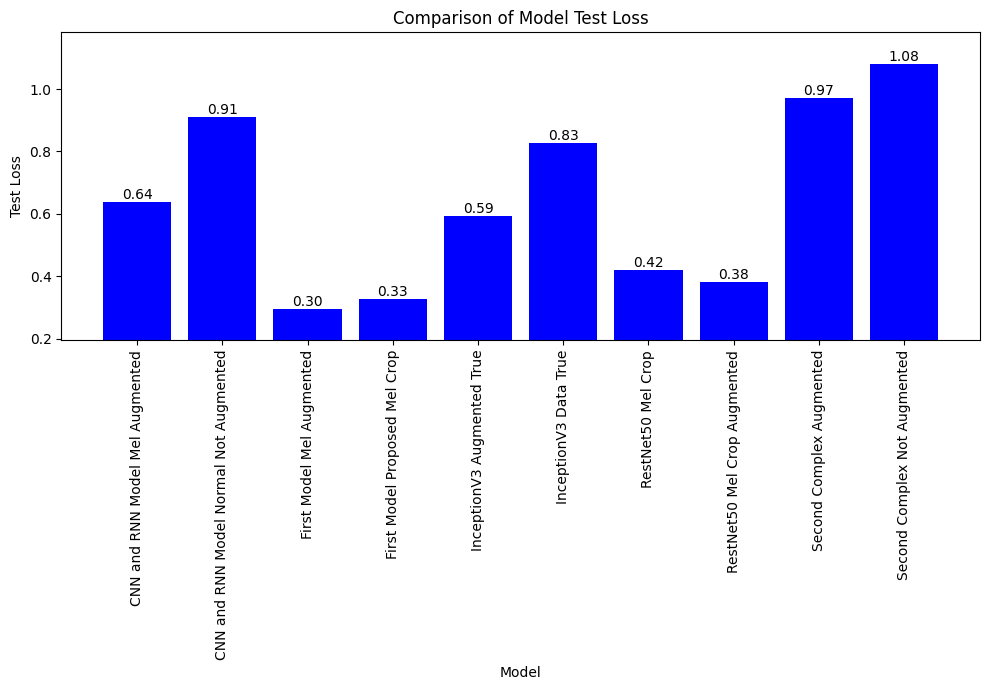

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the model names and file paths
model_names = [
    "CNN and RNN Model Mel Augmented",
    "CNN and RNN Model Normal Not Augmented",
    "First Model Mel Augmented",
    "First Model Proposed Mel Crop",
    "InceptionV3 Augmented True",
    "InceptionV3 Data True",
    "RestNet50 Mel Crop",
    "RestNet50 Mel Crop Augmented",
    "Second Complex Augmented",
    "Second Complex Not Augmented"
]
file_paths = [
    '/content/drive/MyDrive/DeepLearningProject/models_trained/cnn_and_rnn_model_mel_augmented.h5',
    '/content/drive/MyDrive/DeepLearningProject/models_trained/cnn_and_rnn_model_NORMAL_NOT_augmented.h5',
    '/content/drive/MyDrive/DeepLearningProject/models_trained/first_model_mel_augmented.h5',
    '/content/drive/MyDrive/DeepLearningProject/models_trained/first_model_proposed_mel_crop.h5',
    '/content/drive/MyDrive/DeepLearningProject/models_trained/INCEPTIONv3_augmented_true.h5',
    '/content/drive/MyDrive/DeepLearningProject/models_trained/INCEPTIONv3_data_true.h5',
    '/content/drive/MyDrive/DeepLearningProject/models_trained/restnet50_mel_crop.h5',
    '/content/drive/MyDrive/DeepLearningProject/models_trained/restnet50_mel_crop_augmented.h5',
    '/content/drive/MyDrive/DeepLearningProject/models_trained/second_complex_cnn_augmented.h5',
    '/content/drive/MyDrive/DeepLearningProject/models_trained/second_complex_cnn_not_aumented_normal_data.h5'
]

# Load the models and evaluate them
losses = []
for model_name, file_path in zip(model_names, file_paths):
    model = tf.keras.models.load_model(file_path)
    loss, accuracy = model.evaluate(spec_data_test)  # Assuming you have your test data in spec_data_test variable
    losses.append(loss)
    print("Test loss of {}: {:.2f}".format(model_name, loss))

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.bar(model_names, losses, color='blue')
ax.set_xlabel("Model")
ax.set_ylabel("Test Loss", color='black')
ax.set_title("Comparison of Model Test Loss")
ax.set_ylim([min(losses) - 0.1, max(losses) + 0.1])  # Set y-axis limit to emphasize differences
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Display the values on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, "{:.2f}".format(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()
